### Research Objective 
> An investor would like to purchase a private resales property in Singapore. He would like to understand more about the private property resales prices. He is also deciding whether to buy a high floor, mid floor or low floor unit. 

### Business Question 1
> The investor would like to know if the sample mean price of property is representative of the population mean price of property.

### Business Question 2
> The investor would also like to find out if there are any differences in price of property vs floor level (low, mid, high).

### Research Design
> This is a descriptive research.

### Assumption
#### Dataset from URA is the population dataset 
#### https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox 
from scipy.special import inv_boxcox
from statsmodels.stats.weightstats import ztest
import statsmodels.formula.api as smf             #use statsmodel formula
from statsmodels.formula.api import ols           #ols
from statsmodels.stats.anova import anova_lm      #fit the anova table
import statsmodels.stats.multicomp as multi       #used for tukey-hsd
import statsmodels.api as sm                      #check if residual are normally distributed
from scipy.stats import kruskal
import warnings
warnings.filterwarnings("ignore")

### Read CSV File

In [2]:
# read from csv and create a dataframe
# view the first 5 lines
df_1 = pd.read_csv('Private Property Resales D1-D5.csv')
df_2 = pd.read_csv('Private Property Resales D6-D10.csv')
df_3 = pd.read_csv('Private Property Resales D11-D15.csv')
df_4 = pd.read_csv('Private Property Resales D16-D20.csv')
df_5 = pd.read_csv('Private Property Resales D21-D25.csv')
df_6 = pd.read_csv('Private Property Resales D26-D28.csv')

# concatenate two dataframes into one
df=pd.concat([df_1,df_2,df_3,df_4,df_5,df_6])
df.head()

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
0,1,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,Resale,1,1691910,-,732,Strata,11 to 15,2312,May-21
1,2,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,99 yrs lease commencing from 2004,Resale,1,1600000,-,1033,Strata,16 to 20,1548,May-21
2,3,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,99 yrs lease commencing from 2005,Resale,1,1800000,-,1302,Strata,26 to 30,1382,May-21
3,4,CARABELLE,WEST COAST WAY,Condominium,5,OCR,956 yrs lease commencing from 1928,Resale,1,1270000,-,883,Strata,01 to 05,1439,May-21
4,5,QUEENS,STIRLING ROAD,Condominium,3,RCR,99 yrs lease commencing from 1998,Resale,1,1595000,-,1195,Strata,11 to 15,1335,May-21


In [3]:
# dataframe.shape
df.shape

(49206, 16)

> We can see that there are 49206 rows and 16 columns.

In [4]:
# check for unique values 
df['Nett Price ($)'].unique()

array(['-'], dtype=object)

> Since nett price is blank and S/N is not needed, we can drop the columns.

In [5]:
# reset index
df = df.reset_index(drop=True)
# drop column 
df.drop(columns=['S/N','Nett Price ($)'], inplace=True)

In [6]:
df

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,Resale,1,1691910,732,Strata,11 to 15,2312,May-21
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,99 yrs lease commencing from 2004,Resale,1,1600000,1033,Strata,16 to 20,1548,May-21
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,99 yrs lease commencing from 2005,Resale,1,1800000,1302,Strata,26 to 30,1382,May-21
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,956 yrs lease commencing from 1928,Resale,1,1270000,883,Strata,01 to 05,1439,May-21
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,99 yrs lease commencing from 1998,Resale,1,1595000,1195,Strata,11 to 15,1335,May-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49201,EIGHT COURTYARDS,CANBERRA DRIVE,Condominium,27,OCR,99 yrs lease commencing from 2010,Resale,1,1015000,1087,Strata,01 to 05,934,May-16
49202,EUPHONY GARDENS,JALAN MATA AYER,Condominium,27,OCR,99 yrs lease commencing from 1998,Resale,1,1000000,1453,Strata,01 to 05,688,May-16
49203,SERENITY PARK,TAMARIND ROAD,Condominium,28,OCR,Freehold,Resale,1,1030000,1324,Strata,01 to 05,778,May-16
49204,THE MILTONIA RESIDENCES,MILTONIA CLOSE,Condominium,27,OCR,99 yrs lease commencing from 2010,Resale,1,1530000,2077,Strata,01 to 05,736,May-16


### EDA & Data Wranggling

### Preliminary Cleaning

In [7]:
# obtain summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49206 entries, 0 to 49205
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Project Name       49206 non-null  object
 1   Street Name        49206 non-null  object
 2   Type               49206 non-null  object
 3   Postal District    49206 non-null  int64 
 4   Market Segment     49206 non-null  object
 5   Tenure             49205 non-null  object
 6   Type of Sale       49206 non-null  object
 7   No. of Units       49206 non-null  int64 
 8   Price ($)          49206 non-null  int64 
 9   Area (Sqft)        49206 non-null  int64 
 10  Type of Area       49206 non-null  object
 11  Floor Level        49206 non-null  object
 12  Unit Price ($psf)  49206 non-null  int64 
 13  Date of Sale       49206 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.3+ MB


In [8]:
# check whether the columns have any missing values
print(df.isnull().any())
print('---------------')
# obtain list of columns with missing values
print(df.columns[df.isnull().any()])

Project Name         False
Street Name          False
Type                 False
Postal District      False
Market Segment       False
Tenure                True
Type of Sale         False
No. of Units         False
Price ($)            False
Area (Sqft)          False
Type of Area         False
Floor Level          False
Unit Price ($psf)    False
Date of Sale         False
dtype: bool
---------------
Index(['Tenure'], dtype='object')


> From the above, we can see that Tenure has a blank value.

In [9]:
# obtain no of missing values per column
print(df.isnull().sum())
print('---------------')
# obtain total no of missing values by column
print(df.isnull().sum().sum())

Project Name         0
Street Name          0
Type                 0
Postal District      0
Market Segment       0
Tenure               1
Type of Sale         0
No. of Units         0
Price ($)            0
Area (Sqft)          0
Type of Area         0
Floor Level          0
Unit Price ($psf)    0
Date of Sale         0
dtype: int64
---------------
1


> We have a total of 1 missing value in Tenure.

In [10]:
# check whether the rows have any missing values
print(df.isnull().any(axis=1))
print('---------------')
# obtain list of rows with missing values
print(df.index[df.isnull().any(axis=1)])

0        False
1        False
2        False
3        False
4        False
         ...  
49201    False
49202    False
49203    False
49204    False
49205    False
Length: 49206, dtype: bool
---------------
Int64Index([25399], dtype='int64')


> We can see that we do not have any rows that have missing values.

In [11]:
# obtain no of missing values per row
print(df.isnull().sum(axis=1))
print('---------------')
# obtain total no of missing values by row
print(df.isnull().sum(axis=1).sum())

0        0
1        0
2        0
3        0
4        0
        ..
49201    0
49202    0
49203    0
49204    0
49205    0
Length: 49206, dtype: int64
---------------
1


In [12]:
# show all records info that has missing data
df[df.isnull().any(axis=1)]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
25399,EMERY POINT,IPOH LANE,Apartment,15,RCR,NaN,Resale,1,725000,1302,Strata,01 to 05,557,Jul-17


In [13]:
# fill missing value with specific value 
df = df.fillna({'Tenure': 'Freehold'})
# read specific row
print(df.loc[25399])

Project Name         EMERY POINT
Street Name            IPOH LANE
Type                   Apartment
Postal District               15
Market Segment               RCR
Tenure                  Freehold
Type of Sale              Resale
No. of Units                   1
Price ($)                 725000
Area (Sqft)                 1302
Type of Area              Strata
Floor Level             01 to 05
Unit Price ($psf)            557
Date of Sale              Jul-17
Name: 25399, dtype: object


### Check for duplicated rows in dataset

In [14]:
# check for duplicated rows
df[df.duplicated()]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
98,HERITAGE VIEW,DOVER RISE,Condominium,5,RCR,99 yrs lease commencing from 1996,Resale,1,1200000,969,Strata,01 to 05,1239,May-21
394,THE OCEANFRONT @ SENTOSA COVE,OCEAN DRIVE,Condominium,4,CCR,99 yrs lease commencing from 2005,Resale,1,3435000,2013,Strata,01 to 05,1707,Mar-21
421,MARINA COLLECTION,COVE DRIVE,Condominium,4,CCR,99 yrs lease commencing from 2007,Resale,1,6250000,3412,Strata,01 to 05,1832,Mar-21
440,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,4,RCR,99 yrs lease commencing from 1999,Resale,1,2200000,1335,Strata,01 to 05,1648,Mar-21
677,SEASCAPE,COVE WAY,Condominium,4,CCR,99 yrs lease commencing from 2007,Resale,1,6000000,2852,Strata,06 to 10,2103,Jan-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48630,CASTLE GREEN,YIO CHU KANG ROAD,Condominium,26,OCR,99 yrs lease commencing from 1993,Resale,1,940000,1152,Strata,01 to 05,816,Dec-17
48645,THE MILTONIA RESIDENCES,MILTONIA CLOSE,Condominium,27,OCR,99 yrs lease commencing from 2010,Resale,1,830000,861,Strata,01 to 05,964,Dec-17
48682,SERENITY PARK,TAMARIND ROAD,Condominium,28,OCR,Freehold,Resale,1,1330000,1432,Strata,01 to 05,929,Nov-17
48937,THE MILTONIA RESIDENCES,MILTONIA CLOSE,Condominium,27,OCR,99 yrs lease commencing from 2010,Resale,1,588000,517,Strata,01 to 05,1138,Apr-17


> From the above, we have a total of 190 rows that are duplicated.

In [15]:
df1=df.copy()

In [16]:
# dataframe.shape
df1.shape

(49206, 14)

In [17]:
# drop duplicates
df1.drop_duplicates(keep=False,inplace=True)

In [18]:
# dataframe.shape
df1.shape

(48850, 14)

In [19]:
# check for duplicated rows
df1[df1.duplicated()]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale


> We drop the duplicated rows in our dataset.

### Rename Column Names

In [20]:
# change name of columns
df1.rename(columns= {'Project Name':'project_name',
                     'Street Name':'street_name',
                     'Type':'type',
                     'Postal District':'postal_district',
                     'Market Segment':'market_segment',
                     'Tenure':'tenure',
                     'Type of Sale':'type_of_sale',
                     'No. of Units':'no_of_units', 
                     'Price ($)':'price',
                     'Nett Price ($)':'nett_price',
                     'Area (Sqft)':'area',
                     'Type of Area':'type_of_area',
                     'Floor Level':'floor_level',
                     'Unit Price ($psf)':'unit_price',
                     'Date of Sale':'date_of_sale'}, inplace=True)
df1.head()

,project_name,street_name,type,postal_district,market_segment,tenure,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,date_of_sale
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,Resale,1,1691910,732,Strata,11 to 15,2312,May-21
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,99 yrs lease commencing from 2004,Resale,1,1600000,1033,Strata,16 to 20,1548,May-21
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,99 yrs lease commencing from 2005,Resale,1,1800000,1302,Strata,26 to 30,1382,May-21
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,956 yrs lease commencing from 1928,Resale,1,1270000,883,Strata,01 to 05,1439,May-21
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,99 yrs lease commencing from 1998,Resale,1,1595000,1195,Strata,11 to 15,1335,May-21


### Extract number of lease and year from tenure

In [21]:
# extract numbers and join them in a string
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

df1['tenure']=df1['tenure'].apply(str)
df1['number']=df1['tenure'].apply(lambda x: find_number(x))
# split a string column
df1[['lease','lease_commencement']]=df1['number'].str.split(' ',expand=True)
# # drop column 
df1.drop(columns=['tenure','number'], inplace=True) 
df1

,project_name,street_name,type,postal_district,market_segment,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,date_of_sale,lease,lease_commencement
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,Resale,1,1691910,732,Strata,11 to 15,2312,May-21,99,2011
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,Resale,1,1600000,1033,Strata,16 to 20,1548,May-21,99,2004
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,Resale,1,1800000,1302,Strata,26 to 30,1382,May-21,99,2005
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,Resale,1,1270000,883,Strata,01 to 05,1439,May-21,956,1928
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,Resale,1,1595000,1195,Strata,11 to 15,1335,May-21,99,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49201,EIGHT COURTYARDS,CANBERRA DRIVE,Condominium,27,OCR,Resale,1,1015000,1087,Strata,01 to 05,934,May-16,99,2010
49202,EUPHONY GARDENS,JALAN MATA AYER,Condominium,27,OCR,Resale,1,1000000,1453,Strata,01 to 05,688,May-16,99,1998
49203,SERENITY PARK,TAMARIND ROAD,Condominium,28,OCR,Resale,1,1030000,1324,Strata,01 to 05,778,May-16,,None
49204,THE MILTONIA RESIDENCES,MILTONIA CLOSE,Condominium,27,OCR,Resale,1,1530000,2077,Strata,01 to 05,736,May-16,99,2010


### Replace empty values in lease and lease commencement with 0

In [22]:
# replace empty strings with NaN
df1 = df1.replace(r'^\s*$', np.NaN, regex=True)
# fill missing values with specific values
# freehold: lease 0, lease commemcement 0
df1 = df1.fillna({'lease':0, 'lease_commencement':0})
df1

,project_name,street_name,type,postal_district,market_segment,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,date_of_sale,lease,lease_commencement
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,Resale,1,1691910,732,Strata,11 to 15,2312,May-21,99,2011
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,Resale,1,1600000,1033,Strata,16 to 20,1548,May-21,99,2004
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,Resale,1,1800000,1302,Strata,26 to 30,1382,May-21,99,2005
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,Resale,1,1270000,883,Strata,01 to 05,1439,May-21,956,1928
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,Resale,1,1595000,1195,Strata,11 to 15,1335,May-21,99,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49201,EIGHT COURTYARDS,CANBERRA DRIVE,Condominium,27,OCR,Resale,1,1015000,1087,Strata,01 to 05,934,May-16,99,2010
49202,EUPHONY GARDENS,JALAN MATA AYER,Condominium,27,OCR,Resale,1,1000000,1453,Strata,01 to 05,688,May-16,99,1998
49203,SERENITY PARK,TAMARIND ROAD,Condominium,28,OCR,Resale,1,1030000,1324,Strata,01 to 05,778,May-16,0,0
49204,THE MILTONIA RESIDENCES,MILTONIA CLOSE,Condominium,27,OCR,Resale,1,1530000,2077,Strata,01 to 05,736,May-16,99,2010


### Split date of sale to get month and year

In [23]:
# split a string column
df1[['month','year']]=df1['date_of_sale'].str.split('-',expand=True)
# drop column
df1.drop(columns=['date_of_sale'], inplace=True)
df1.head()

,project_name,street_name,type,postal_district,market_segment,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,lease,lease_commencement,month,year
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,Resale,1,1691910,732,Strata,11 to 15,2312,99,2011,May,21
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,Resale,1,1600000,1033,Strata,16 to 20,1548,99,2004,May,21
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,Resale,1,1800000,1302,Strata,26 to 30,1382,99,2005,May,21
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,Resale,1,1270000,883,Strata,01 to 05,1439,956,1928,May,21
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,Resale,1,1595000,1195,Strata,11 to 15,1335,99,1998,May,21


In [24]:
# datatypes
df1.dtypes

project_name          object
street_name           object
type                  object
postal_district        int64
market_segment        object
type_of_sale          object
no_of_units            int64
price                  int64
area                   int64
type_of_area          object
floor_level           object
unit_price             int64
lease                 object
lease_commencement    object
month                 object
year                  object
dtype: object

In [25]:
# dataframe.shape
df1.shape

(48850, 16)

### Change lease commencement and year to be integer

In [26]:
# conversion of datatypes from object to integer
df1['lease']=df1['lease'].astype(int)
df1['lease_commencement']=df1['lease_commencement'].astype(int)
df1['year']=df1['year'].astype(int)
df1.dtypes

project_name          object
street_name           object
type                  object
postal_district        int64
market_segment        object
type_of_sale          object
no_of_units            int64
price                  int64
area                   int64
type_of_area          object
floor_level           object
unit_price             int64
lease                  int32
lease_commencement     int32
month                 object
year                   int32
dtype: object

### Create column for remaining lease

In [27]:
# create column for remaining lease
df1['remaining_lease'] = df1['lease_commencement'] + df1['lease'] - 2021 
df1.head()

,project_name,street_name,type,postal_district,market_segment,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,lease,lease_commencement,month,year,remaining_lease
0,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,Resale,1,1691910,732,Strata,11 to 15,2312,99,2011,May,21,89
1,DOMAIN 21,DELTA ROAD,Condominium,3,RCR,Resale,1,1600000,1033,Strata,16 to 20,1548,99,2004,May,21,82
2,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,Apartment,5,RCR,Resale,1,1800000,1302,Strata,26 to 30,1382,99,2005,May,21,83
3,CARABELLE,WEST COAST WAY,Condominium,5,OCR,Resale,1,1270000,883,Strata,01 to 05,1439,956,1928,May,21,863
4,QUEENS,STIRLING ROAD,Condominium,3,RCR,Resale,1,1595000,1195,Strata,11 to 15,1335,99,1998,May,21,76


### Descriptive Statistics on Resale Price

In [28]:
# generate descriptive statistics based on resale price
df1['price'].describe()

count    4.885000e+04
mean     2.090048e+06
std      1.394925e+07
min      4.000000e+05
25%      9.850000e+05
50%      1.330000e+06
75%      1.860000e+06
max      9.800000e+08
Name: price, dtype: float64

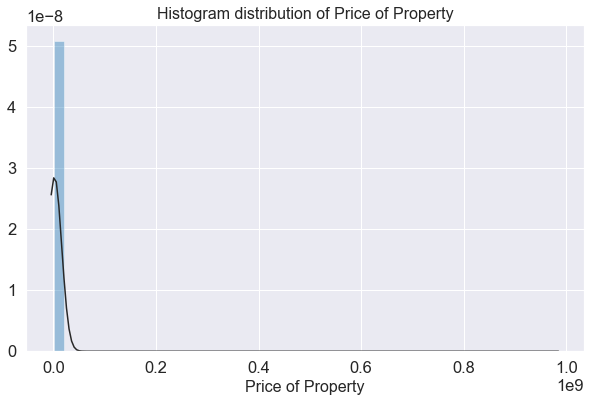

In [29]:
#optionals: setting notebook theme, etc... for EDA
plt.rcParams["figure.figsize"] = [10,6]
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

sns.distplot(df1['price'],fit=stats.norm,kde=False)
#super imposed the normal curve to the histogram or distribution, 
#KDE curve is set to false cuz default is True.

plt.title('Histogram distribution of Price of Property')
plt.xlabel('Price of Property')
plt.show()

#positively skewed (right skewed)

> We can see from the above that we cannot see the histogram because of the scale of the X axis. Hence we need to use Log scale / Boxcox to rescale the X axis

### Apply Log to price

In [30]:
# apply log to price
df1['price_log'] = np.log(df1['price'])

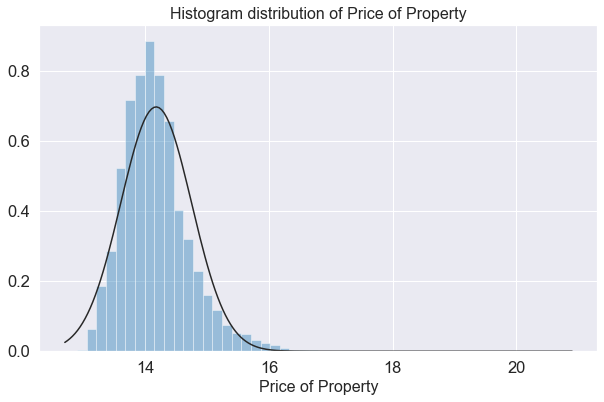

In [31]:
#optionals: setting notebook theme, etc... for EDA
plt.rcParams["figure.figsize"] = [10,6]
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

sns.distplot(df1['price_log'],fit=stats.norm,kde=False)
#super imposed the normal curve to the histogram or distribution, 
#KDE curve is set to false cuz default is True.

plt.title('Histogram distribution of Price of Property')
plt.xlabel('Price of Property')
plt.show()

#positively skewed (right skewed)

In [32]:
# calculate skew of distribution 
# a positively skewed (or right-skewed) distribution
df1['price_log'].skew()

1.761126225516022

In [33]:
# calculate kurtosis of distribution 
df1['price_log'].kurtosis()

9.589149986698189

### Apply Boxcox to price

In [34]:
# transform price data & save lambda value
normalized_data, fitted_lambda = stats.boxcox(df1['price'])

In [35]:
# use lambda value to transform price data
df1['price_BX'] = stats.boxcox(df1['price'], fitted_lambda)

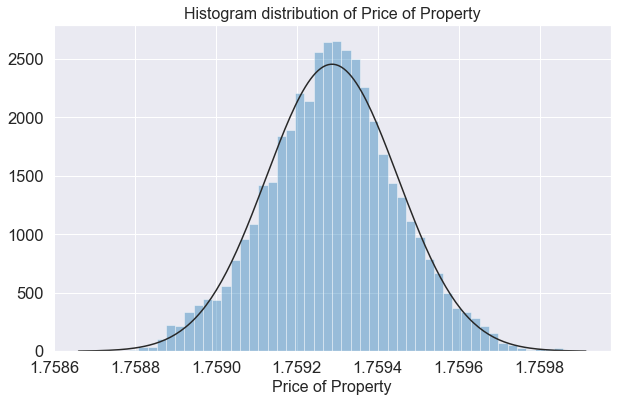

In [36]:
#optionals: setting notebook theme, etc... for EDA
plt.rcParams["figure.figsize"] = [10,6]
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

sns.distplot(df1['price_BX'],fit=stats.norm,kde=False)
#super imposed the normal curve to the histogram or distribution, 
#KDE curve is set to false cuz default is True.

plt.title('Histogram distribution of Price of Property')
plt.xlabel('Price of Property')
plt.show()

#positively skewed (right skewed)

> We can see from the above transformation, Boxcox did a better job in transforming the data to be near normal. However we need to do a normality test to confirm it

In [37]:
# calculate skew of distribution 
# roughly normal
df1['price_BX'].skew()

-0.0030211500382591547

In [38]:
# calculate kurtosis of distribution 
df1['price_BX'].kurtosis()

0.0404657844481755

### Comparison of Boxplot

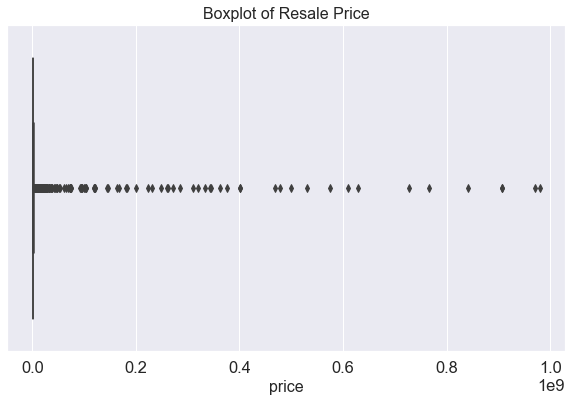

In [39]:
# plot a boxplot based on price
sns.boxplot(x=df1['price']).set_title('Boxplot of Resale Price')
plt.show()

> From the box plot on price, we are not able to see any good result on the price. Hence we need to rescale price using log and boxcox

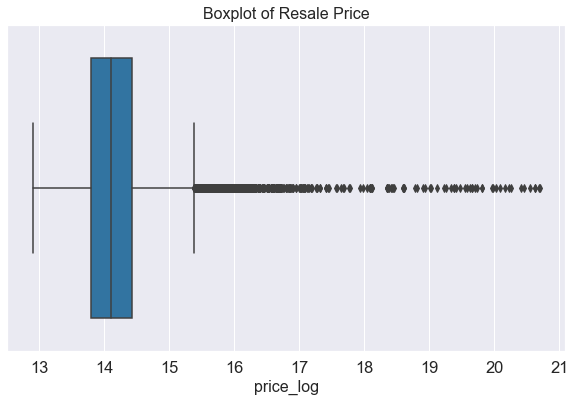

In [40]:
# plot a boxplot based on price
sns.boxplot(x=df1['price_log']).set_title('Boxplot of Resale Price')
plt.show()

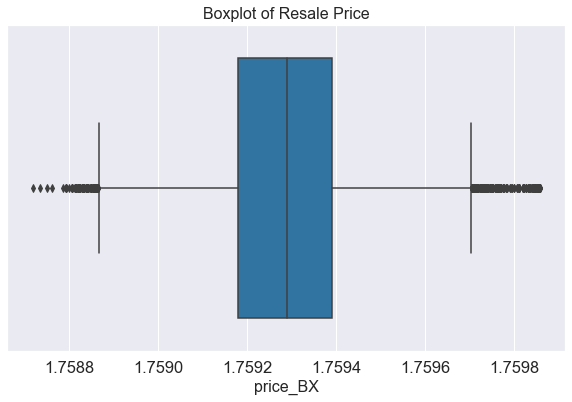

In [41]:
# plot a boxplot based on price
sns.boxplot(x=df1['price_BX']).set_title('Boxplot of Resale Price')
plt.show()

### Comparison of QQ Plot

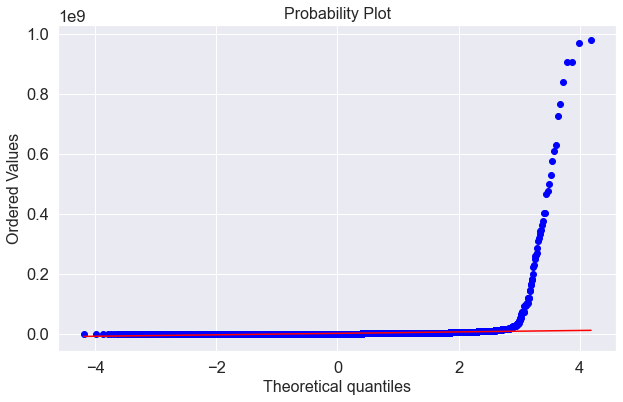

In [42]:
# plot a qq plot 
res=stats.probplot(df1['price'], plot=plt)

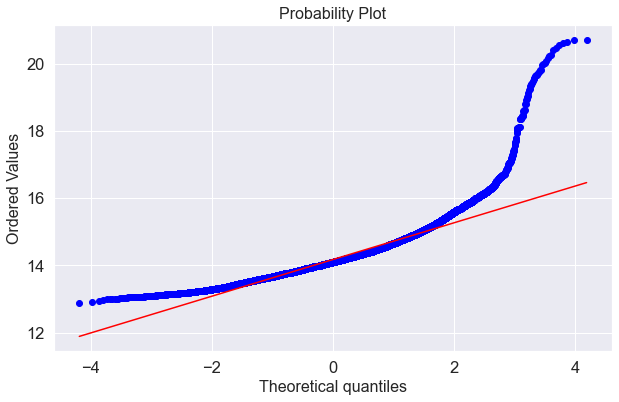

In [43]:
# plot a qq plot 
res=stats.probplot(df1['price_log'], plot=plt)

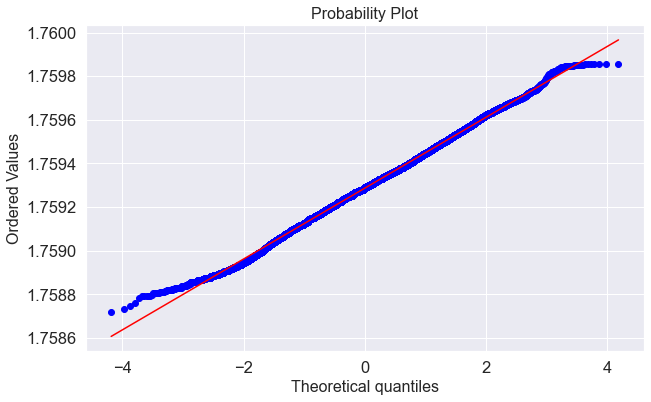

In [44]:
# plot a qq plot 
res=stats.probplot(df1['price_BX'], plot=plt)

> From the above, we can see that with the Boxcox transformation on price, the QQ plot is roughly normal. 

### Normality Test

### On Price

In [45]:
# D'Agostino's K^2 Normality Test
from scipy.stats import normaltest

stat, p = normaltest(df1['price'])         

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=151830.768, p=0.000
Probably not Gaussian


### On price after Log transformation

In [46]:
# D'Agostino's K^2 Normality Test
from scipy.stats import normaltest

stat, p = normaltest(df1['price_log'])         

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=20691.619, p=0.000
Probably not Gaussian


### On price after Boxcox transformation

In [47]:
# D'Agostino's K^2 Normality Test
from scipy.stats import normaltest

stat, p = normaltest(df1['price_BX'])         

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=3.318, p=0.190
Probably Gaussian


> We can see that with the Boxcox transformation on price, it has passed the normality test.

> In order to conduct a Parametric Test, we need to check for:
> 1) Normality of distribution/ Gaussian Distribution
> 2) Homoscedasticity or Homogeneity of Variance
> 3) Independance between rows, that each row of data has been drawn independently of others
> 4) Dependent Variable (Price) is continuous

### Perform Inverse Boxcox

In [48]:
# perform reverse Box-Cox transformation on transformed data
df1['RBX_price']=inv_boxcox(df1['price_BX'],fitted_lambda)
df1['RBX_price']

0        1.691910e+06
1        1.600000e+06
2        1.800000e+06
3        1.270000e+06
4        1.595000e+06
             ...     
49201    1.015000e+06
49202    1.000000e+06
49203    1.030000e+06
49204    1.530000e+06
49205    1.700000e+06
Name: RBX_price, Length: 48850, dtype: float64

### For Business Question 1

### Z Test with random sampling 

In [49]:
# calculate the population mean
average = round(df1['RBX_price'].mean())
print(average)

2090048


### 1 sample Z Test about population mean

In [50]:
# conduct a random sampling
df1_randsample = df1.sample(frac=0.25, random_state=0)
df1_randsample

,project_name,street_name,type,postal_district,market_segment,type_of_sale,no_of_units,price,area,type_of_area,floor_level,unit_price,lease,lease_commencement,month,year,remaining_lease,price_log,price_BX,RBX_price
24008,NIN RESIDENCE,PHENG GECK AVENUE,Apartment,13,RCR,Resale,1,857800,635,Strata,01 to 05,1351,99,2010,Nov,17,88,13.662126,1.759123,8.578000e+05
32682,AQUARIUS BY THE PARK,BEDOK RESERVOIR VIEW,Condominium,16,OCR,Resale,1,1220000,1227,Strata,16 to 20,994,99,1996,Jul,19,74,14.014361,1.759259,1.220000e+06
47177,YISHUN EMERALD,CANBERRA DRIVE,Condominium,27,OCR,Resale,1,835000,1206,Strata,06 to 10,693,99,1998,Dec,20,76,13.635187,1.759112,8.350000e+05
11623,THE PIER AT ROBERTSON,MOHAMED SULTAN ROAD,Apartment,9,CCR,Resale,1,1430000,732,Strata,06 to 10,1954,0,0,Feb,18,-2021,14.173185,1.759312,1.430000e+06
2587,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,4,RCR,Resale,1,2520000,1636,Strata,01 to 05,1540,99,1999,Jun,19,77,14.739769,1.759466,2.520000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12534,PARC EMILY,MOUNT EMILY ROAD,Condominium,9,CCR,Resale,1,2780000,1733,Strata,06 to 10,1604,0,0,Sep,17,-2021,14.837961,1.759488,2.780000e+06
10530,THE SUITES AT CENTRAL,DEVONSHIRE ROAD,Condominium,9,CCR,Resale,1,3330000,1378,Strata,11 to 15,2417,0,0,Jul,18,-2021,15.018483,1.759525,3.330000e+06
4154,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,4,RCR,Resale,1,2600000,1668,Strata,01 to 05,1558,99,1999,Feb,18,77,14.771022,1.759473,2.600000e+06
12807,RV RESIDENCES,RIVER VALLEY ROAD,Condominium,10,CCR,Resale,1,1341880,678,Strata,01 to 05,1979,999,1877,Aug,17,855,14.109582,1.759291,1.341880e+06


In [51]:
# calculate the sample mean
sample_average = round(df1_randsample['RBX_price'].mean())
print(sample_average)

2003699


### Testing the hypothesis that the mean is 2090048 against the alternative that it is not
$\begin{align}
  & {{H}_{0}}:\,\mu =\,{{\mu }_{0}} \\ 
 & {{H}_{1}}:\,\mu \ne {{\mu }_{0}} \\ 
\end{align}$

In [52]:
# The investor claims that the average price of the private resales property in Singapore is $2090048.
# However, the property agent feels that the average price of the private resales property in Singapore is not $2090048.
# Is there enough evidence at 5% level of significance to conclude that the average price of the resales property is $2090048?

In [53]:
# use of z test
(test_statistic, p_value) = ztest(df1_randsample['RBX_price'], value=average, alternative='two-sided', ddof=1.0)
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
# at 0.05 level of significance, we fail to reject the null hypothesis since p-value of 0.44052 > 0.05 
# conclude there is enough evidence that average price of the property is $2090048.

The test statistic is:  -0.77131
The p-value is:  0.44052


### Testing the hypothesis that the mean is 2090048 against the alternative that it is greater
$\begin{align}
  & {{H}_{0}}:\mu ={{\mu }_{0}} \\ 
 & {{H}_{1}}:\mu >{{\mu }_{0}} \\ 
\end{align}$  

In [54]:
# The investor claims that the average price of the private resales property in Singapore is $2090048.
# However, the property agent feels that the average price of the private resales property in Singapore is greater than $2090048.
# Is there enough evidence at 5% level of significance to conclude that the average price of the resales property is $2090048?

In [55]:
# use of z test
(test_statistic, p_value) = ztest(df1_randsample['RBX_price'], value=average, alternative='larger', ddof=1.0)
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
# at 0.05 level of significance, we fail to reject the null hypothesis since p-value of 0.77974 > 0.05 
# conclude there is enough evidence that average price of the property is $2090048.

The test statistic is:  -0.77131
The p-value is:  0.77974


### Testing the hypothesis that the mean is 2090048 against the alternative that it is smaller
$\begin{align}
  & {{H}_{0}}:\mu ={{\mu }_{0}} \\ 
 & {{H}_{1}}:\mu < {{\mu }_{0}} \\ 
\end{align}$  

In [56]:
# The investor claims that the average price of the private resales property in Singapore is $2090048.
# However, the property agent feels that the average price of the private resales property in Singapore is lesser than $2090048.
# Is there enough evidence at 5% level of significance to conclude that the average price of the resales property is $2090048?

In [57]:
# use of z test
(test_statistic, p_value) = ztest(df1_randsample['RBX_price'], value=average, alternative='smaller', ddof=1.0)
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
# at 0.05 level of significance, we fail to reject the null hypothesis since p-value of 0.22026 > 0.05 
# conclude there is enough evidence that average price of the property is $2090048.

The test statistic is:  -0.77131
The p-value is:  0.22026


### Result

> The sample mean price of property is representative of the population mean price of property.

### Group floor level to 3 main groups Low (B1 to 20), Mid (21 to 45) and High (46 onwards to 75)

In [58]:
# group floor level to low, mid, high
df1['floor_level']=df1['floor_level'].replace({'-': 'low'})
df1['floor_level']=df1['floor_level'].replace({'B1 to B5': 'low'})
df1['floor_level']=df1['floor_level'].replace({'01 to 05': 'low'})
df1['floor_level']=df1['floor_level'].replace({'06 to 10': 'low'})
df1['floor_level']=df1['floor_level'].replace({'11 to 15': 'low'})
df1['floor_level']=df1['floor_level'].replace({'16 to 20': 'low'})
df1['floor_level']=df1['floor_level'].replace({'21 to 25': 'mid'})
df1['floor_level']=df1['floor_level'].replace({'26 to 30': 'mid'})
df1['floor_level']=df1['floor_level'].replace({'31 to 35': 'mid'})
df1['floor_level']=df1['floor_level'].replace({'36 to 40': 'mid'})
df1['floor_level']=df1['floor_level'].replace({'41 to 45': 'mid'})
df1['floor_level']=df1['floor_level'].replace({'46 to 50': 'high'})
df1['floor_level']=df1['floor_level'].replace({'51 to 55': 'high'})
df1['floor_level']=df1['floor_level'].replace({'56 to 60': 'high'})
df1['floor_level']=df1['floor_level'].replace({'61 to 65': 'high'})
df1['floor_level']=df1['floor_level'].replace({'66 to 70': 'high'})
df1['floor_level']=df1['floor_level'].replace({'71 to 75': 'high'})

In [59]:
resale_price1 = df1['RBX_price'][df1['floor_level']=='low']
resale_price2 = df1['RBX_price'][df1['floor_level']=='mid']
resale_price3 = df1['RBX_price'][df1['floor_level']=='high']

In [60]:
df1.floor_level.unique()

array(['low', 'mid', 'high'], dtype=object)

### Testing equality of variances with Levene Test

\begin{align}
  & {{H}_{0}}:\,\,\sigma _{1}^{2}\,=\,\,\sigma _{2}^{2} \,=\,\,\sigma _{3}^{2}\\ 
 & {{H}_{1}}:\,\,\sigma _{1}^{2}\,\ne \,\,\sigma _{2}^{2}\,\ne \,\,\sigma _{3}^{2} \\ 
\end{align}

> H0 : they have the same variance in all groups <br>
> H1 : they are different in some groups than in others

In [61]:
# use of levene test to test if the variances of these groups are the same
(test_statistic, p_value) = stats.levene(resale_price1, resale_price2, resale_price3)
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
# at 0.05 level of significance, we fail to reject the null hypothesis since p-value of 0.50364 > 0.05 
# conclude there is enough evidence that they have the same variances

The test statistic is:  0.6859
The p-value is:  0.50364


### For Business Question 2

### ANOVA Test

> Anova Test allows more than 2 groups.
> We have more than 2 groups (3 intragroups - Low, Mid and High).

\begin{align}
  & {{H}_{0}}:\,\,\mu _{1}\,=\,\,\mu _{2}\,=\,\,\mu _{3} \\
 & {{H}_{1}}:\,\,\mu _{1}\,\ne \,\,\mu _{2}\,\ne \,\,\mu _{3} \\ 
\end{align}

> H0 : they have the same distribution for the resale transaction in all groups <br>
> H1 : they are different in some groups than in others

In [62]:
pivoted_cdf = df1.pivot( columns='floor_level', values='RBX_price')

In [63]:
model = smf.ols('RBX_price ~ C(floor_level)', data=df1).fit()  
aov_table = anova_lm(model, typ=2)

In [64]:
print(aov_table)
# at 0.05 level of significance, we reject the null hypothesis since p-value of 0.014466 < 0.05 
# conclude there is enough evidence that they have different distributions

                      sum_sq       df         F    PR(>F)
C(floor_level)  1.648391e+15      2.0  4.236293  0.014466
Residual        9.503468e+18  48847.0       NaN       NaN


> dof = 2 groups <br>
> dof = (Low, Mid, High) - 1 <br>
> because p-value (PR(>F)) at 5% level significance, indicates that 0.014466 is less than 0.05. <br>
> thus we reject the null hypothesis in favour of the alternate hypothesis that there are difference in some groups of floor level then in others.

### Post Hoc Test

> Since we have established that there are differences between some groups of floor level than in others, we need to uncover the specific difference when ANOVA F test is significant.

### To find out which pair of treatments are significantly different from each other

### Tukey HSD for multiple comparision

In [65]:
# multiple comparison of resale price for floor_level
mcTreatment    = multi.MultiComparison(df1['RBX_price'], df1['floor_level'])
results_Treatment  = mcTreatment.tukeyhsd()
print(results_Treatment.summary())
# a result of ’reject = True’ means that a significant difference has been observed

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
  high    low -808917.7686 0.6616 -3059546.1693  1441710.632  False
  high    mid -177635.9617    0.9 -2478923.8408 2123651.9174  False
   low    mid  631281.8069  0.014   103365.8687 1159197.7451   True
-------------------------------------------------------------------


> From the above, we can see that the pricing between low and mid are significantly different.

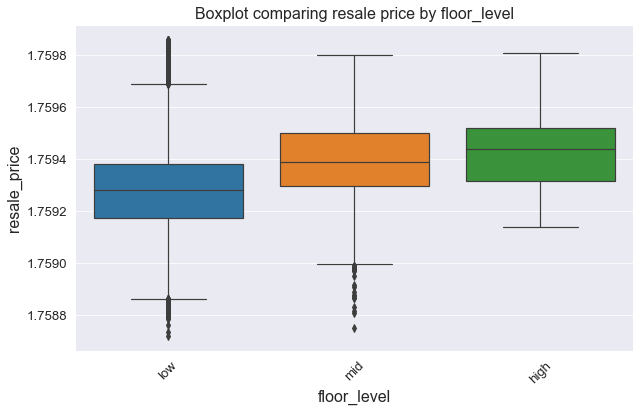

In [66]:
# plot boxplot to ascertain if there is overlap
sns.set_context("paper", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plt.title('Boxplot comparing resale price by floor_level')
sns.boxplot(x='floor_level', y='price_BX', data=df1)
plt.xlabel('floor_level')
plt.ylabel('resale_price')
plt.xticks(rotation=45)
plt.show()

> From the above box plot, we can see that there are indeed differences between low and mid.

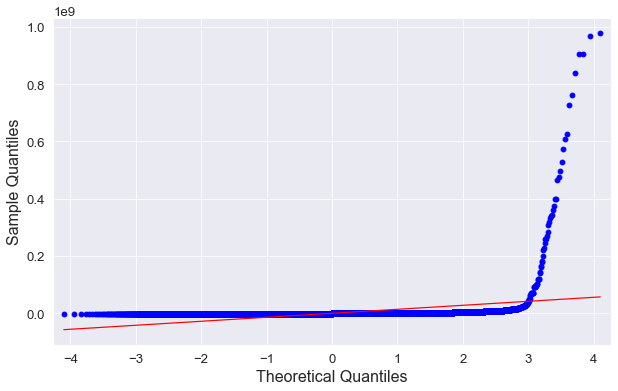

In [67]:
# plot residual plot
residuals = model.resid 
fig = sm.qqplot(residuals, line='s') 
plt.show()

> As the residual is not normally distributed, we will conduct a non-parametric test as well for comparison.

### Comparison with a Non-Parametric Test

\begin{align}
  & {{H}_{0}}:\,\,\mu _{1}\,=\,\,\mu _{2}\,=\,\,\mu _{3} \\
 & {{H}_{1}}:\,\,\mu _{1}\,\ne \,\,\mu _{2}\,\ne \,\,\mu _{3} \\ 
\end{align}

> H0 : they have the same distribution for the resale transaction in all groups <br>
> H1 : they are different in some groups than in others

In [68]:
# use of Kruskal Wallis
stat, p = kruskal(resale_price1, resale_price2, resale_price3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('They have the distributions (fail to reject H0)')
else:
    print('They have different distributions (reject H0)')
# at 0.05 level of significance, we reject the null hypothesis since p-value < 0.05 
# conclude there is enough evidence that they have different distributions

Statistics=2024.077, p=0.000
They have different distributions (reject H0)


### Result

> From both parametric and non-parametric tests, we confirmed that they have different distributions in some groups than in others.<br>
> There are differences in price of property vs floor level.

### Remove Outliers

In [69]:
# identify IQR and lower/upper whiskers
Q1=df1['price_BX'].quantile(0.25)
Q3=df1['price_BX'].quantile(0.75)
IQR=Q3-Q1
print('The 1st Quartile:', Q1)
print('The 3rd Quartile:', Q3)
print('The IQR (50% between 1st to 3rd QR):', IQR)

Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print('The Lower Whisker is : {} and Upper Whisker is {}'.format(Lower_Whisker, Upper_Whisker))

The 1st Quartile: 1.7591797032161516
The 3rd Quartile: 1.7593893831360936
The IQR (50% between 1st to 3rd QR): 0.0002096799199420296
The Lower Whisker is : 1.7588651833362385 and Upper Whisker is 1.7597039030160067


### Before Removal of Outliers

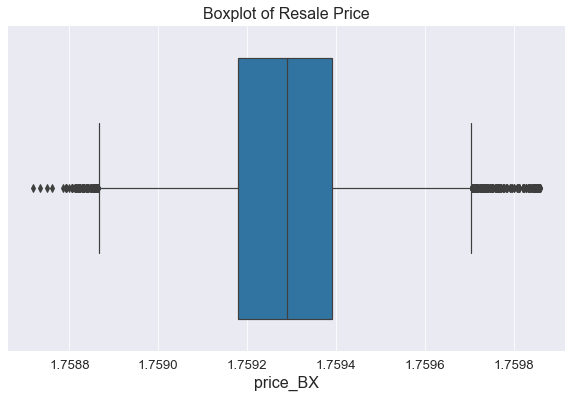

In [70]:
# plot a boxplot based on price before removal of outliers
sns.boxplot(x=df1['price_BX']).set_title('Boxplot of Resale Price')
plt.show()

### After Removal of Outliers

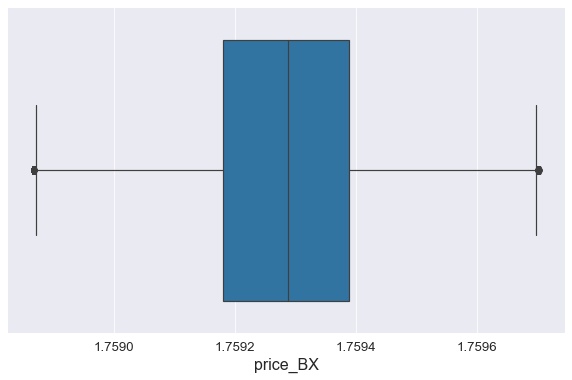

In [71]:
# after removal of outliers
df2 = df1[(df1['price_BX'] < Upper_Whisker) & (df1['price_BX'] > Lower_Whisker)]
#df2 = df1[(df1['price_BX'] < Upper_Whisker)]
#df2 = df1[(df1['price_BX'] > Lower_Whisker)]
sns.boxplot(data=df2,x=df2['price_BX'])

### Re-Run ANOVA

### Group floor level to 3 main groups Low (B1 to 20), Mid (21 to 45) and High (46 onwards to 75)

In [72]:
# group floor level to low, mid, high
df2['floor_level']=df2['floor_level'].replace({'-': 'low'})
df2['floor_level']=df2['floor_level'].replace({'B1 to B5': 'low'})
df2['floor_level']=df2['floor_level'].replace({'01 to 05': 'low'})
df2['floor_level']=df2['floor_level'].replace({'06 to 10': 'low'})
df2['floor_level']=df2['floor_level'].replace({'11 to 15': 'low'})
df2['floor_level']=df2['floor_level'].replace({'16 to 20': 'low'})
df2['floor_level']=df2['floor_level'].replace({'21 to 25': 'mid'})
df2['floor_level']=df2['floor_level'].replace({'26 to 30': 'mid'})
df2['floor_level']=df2['floor_level'].replace({'31 to 35': 'mid'})
df2['floor_level']=df2['floor_level'].replace({'36 to 40': 'mid'})
df2['floor_level']=df2['floor_level'].replace({'41 to 45': 'mid'})
df2['floor_level']=df2['floor_level'].replace({'46 to 50': 'high'})
df2['floor_level']=df2['floor_level'].replace({'51 to 55': 'high'})
df2['floor_level']=df2['floor_level'].replace({'56 to 60': 'high'})
df2['floor_level']=df2['floor_level'].replace({'61 to 65': 'high'})
df2['floor_level']=df2['floor_level'].replace({'66 to 70': 'high'})
df2['floor_level']=df2['floor_level'].replace({'71 to 75': 'high'})

In [73]:
resale_price1 = df2['RBX_price'][df2['floor_level']=='low']
resale_price2 = df2['RBX_price'][df2['floor_level']=='mid']
resale_price3 = df2['RBX_price'][df2['floor_level']=='high']

In [74]:
df2.floor_level.unique()

array(['low', 'mid', 'high'], dtype=object)

### Testing equality of variances with Levene Test

\begin{align}
  & {{H}_{0}}:\,\,\sigma _{1}^{2}\,=\,\,\sigma _{2}^{2} \,=\,\,\sigma _{3}^{2}\\ 
 & {{H}_{1}}:\,\,\sigma _{1}^{2}\,\ne \,\,\sigma _{2}^{2}\,\ne \,\,\sigma _{3}^{2} \\ 
\end{align}

> H0 : they have the same variance in all groups <br>
> H1 : they are different in some groups than in others

In [75]:
# use of levene test to test if the variances of these groups are the same
(test_statistic, p_value) = stats.levene(resale_price1, resale_price2, resale_price3)
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
# at 0.05 level of significance, we reject the null hypothesis since p-value of 0.0 < 0.05 
# conclude that they have the different variance

The test statistic is:  480.04414
The p-value is:  0.0


### ANOVA Test

\begin{align}
  & {{H}_{0}}:\,\,\mu _{1}\,=\,\,\mu _{2}\,=\,\,\mu _{3} \\
 & {{H}_{1}}:\,\,\mu _{1}\,\ne \,\,\mu _{2}\,\ne \,\,\mu _{3} \\ 
\end{align}

> H0 : they have the same distribution for the resale transaction in all groups <br>
> H1 : they are different in some groups than in others

In [76]:
pivoted_cdf = df2.pivot( columns='floor_level', values='RBX_price')

In [77]:
model = smf.ols('RBX_price ~ C(floor_level)', data=df2).fit()  
aov_table = anova_lm(model, typ=2)

In [78]:
print(aov_table)
# at 0.05 level of significance, we reject the null hypothesis since p-value of 0.0 < 0.05 
# conclude there is enough evidence that they have different distributions

                      sum_sq       df            F  PR(>F)
C(floor_level)  3.053868e+15      2.0  1084.547221     0.0
Residual        6.825218e+16  48478.0          NaN     NaN


### Post Hoc Test

> Since we have established that there are differences between some groups of floor level than in others, we need to uncover the specific difference when ANOVA F test is significant.

### To find out which pair of treatments are significantly different from each other

### Tukey HSD for multiple comparision

In [79]:
# multiple comparison of resale price for floor_level
mcTreatment    = multi.MultiComparison(df2['RBX_price'], df2['floor_level'])
results_Treatment  = mcTreatment.tukeyhsd()
print(results_Treatment.summary())
# a result of ’reject = True’ means that a significant difference has been observed

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
  high    low -834844.2111  0.001 -1027665.5147 -642022.9076   True
  high    mid   45579.7918 0.8336  -151582.3879  242741.9715  False
   low    mid  880424.0029  0.001   835220.4166  925627.5892   True
-------------------------------------------------------------------


> From the above we can see that the pricing between 
> low and mid are significantly different
> high and low are significantly different

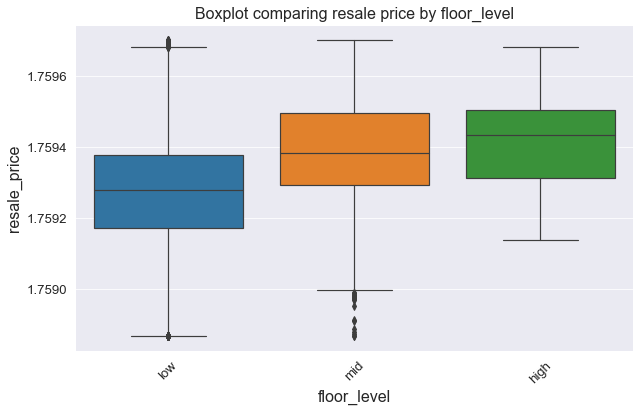

In [80]:
# plot boxplot to ascertain if there is overlap
sns.set_context("paper", font_scale=1.5, rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plt.title('Boxplot comparing resale price by floor_level')
sns.boxplot(x='floor_level', y='price_BX', data=df2)
plt.xlabel('floor_level')
plt.ylabel('resale_price')
plt.xticks(rotation=45)
plt.show()

> From the above box plot, we can see that there are indeed differences between low and mid as well as high and low.

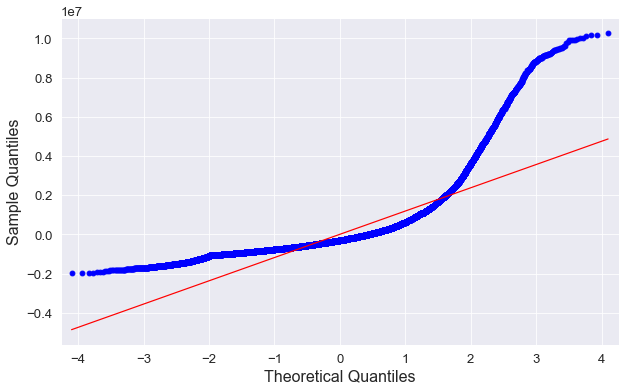

In [81]:
# plot residual plot
residuals = model.resid 
fig = sm.qqplot(residuals, line='s') 
plt.show()

> As the residual is not normally distributed, we will conduct a non-parametric test as well for comparison.

### Comparison with a Non-Parametric Test

\begin{align}
  & {{H}_{0}}:\,\,\mu _{1}\,=\,\,\mu _{2}\,=\,\,\mu _{3} \\
 & {{H}_{1}}:\,\,\mu _{1}\,\ne \,\,\mu _{2}\,\ne \,\,\mu _{3} \\ 
\end{align}

> H0 : they have the same distribution for the resale transaction in all groups <br>
> H1 : they are different in some groups than in others

In [82]:
# use of Kruskal Wallis
stat, p = kruskal(resale_price1, resale_price2, resale_price3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('They have the distributions (fail to reject H0)')
else:
    print('They have different distributions (reject H0)')
# at 0.05 level of significance, we reject the null hypothesis since p-value < 0.05 
# conclude there is enough evidence that they have different distributions

Statistics=1969.681, p=0.000
They have different distributions (reject H0)


### Result

> From both parametric and non-parametric tests, after the removal of outliers, we confirmed that they have different distributions in some groups than in others.<br>
> There are differences in price of property vs floor level.

### Conclusion

> Based on the tests conducted, we conclude that:<br>
> the sample mean price of property is representative of the population mean price of property.<br>
> there are differences in price of property vs floor level.